# Bedbugs

Notebook contenant :
- L'exploration des données
- L'interprétabilité de nos modèles

In [18]:
# Libraries
#----------------------------------------------
import pandas as pd
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt #to plot graphs
import matplotlib.patches as mpatches #to customize legend
import seaborn as sns #to plot graphs
import math 
import os
import re #to find integers & floats in a string 
from collections import Counter #to count values in a dataframe or array
from datetime import date, timedelta, datetime #for the date
import datetime as dt
import pandas as pd
import pickle

# Exploration

## Récupération du test_set et données


In [2]:
# Lecture du fichier des données tests
#----------------------------------------------
PATH = '../data' #modifier si besoin le chemin du fichier
data = pd.read_csv(PATH + '//test_set.csv')

# Assigner le bon type aux variables
#----------------------------------------------
data.drop("index",axis=1,inplace=True) #enlève la colonne index
#--- Convert to integer: 
int_list = ["order_requests","date","avatar_id","hotel_id","stock"]
data[int_list] = data[int_list].astype(int) 
#--- Convert to categorical: 
data["city"] = pd.Categorical(data["city"],ordered=False)
data["language"] = pd.Categorical(data["language"],ordered=False)
data["mobile"] = pd.Categorical(data["mobile"],ordered=False)

data.head()

,order_requests,city,date,language,mobile,avatar_id,hotel_id,stock
0,1,vilnius,21,romanian,0,1,161,46
1,1,vilnius,21,romanian,0,1,187,32
2,1,vilnius,21,romanian,0,1,279,12
3,1,vilnius,21,romanian,0,1,395,10
4,1,vilnius,21,romanian,0,1,488,42


In [3]:
# Lecture du fichier des features hotels
#----------------------------------------------
featuresHotels = pd.read_csv(PATH + "//features_hotels.csv")
# on merge les fichiers featuresHotels et data selon la colonne "hotel_id" pour utilisation ultérieure
all_data = pd.merge(left=data,right=featuresHotels.drop("city",axis=1), #enlève city car présente dans les 2 fichiers
                    how='left', left_on='hotel_id', right_on='hotel_id') 

all_data.head()

,order_requests,city,date,language,mobile,avatar_id,hotel_id,stock,group,brand,parking,pool,children_policy
0,1,vilnius,21,romanian,0,1,161,46,Boss Western,J.Halliday Inn,1,0,0
1,1,vilnius,21,romanian,0,1,187,32,Accar Hotels,Marcure,1,1,0
2,1,vilnius,21,romanian,0,1,279,12,Independant,Independant,1,0,0
3,1,vilnius,21,romanian,0,1,395,10,Accar Hotels,Ibas,0,0,0
4,1,vilnius,21,romanian,0,1,488,42,Accar Hotels,Safitel,1,1,1


## Première descriiption du jeu de données

In [4]:
# Premières stats sur le jeu de données test
#----------------------------------------------
print("Type des données:")
print("--------------------------------------")
print(data.dtypes)

print("\nDescription rapide des données quantitatives\n(affichés en integer pour + de clarté):")
print("--------------------------------------")
print(data.describe().astype(int))

print("\nDescription rapide des données qualitatives:")
print("--------------------------------------")
print(data.describe(include = "category"))

print("\nListe des categories:")
print("--------------------------------------")
print("city: ", data["city"].cat.categories)
print("language: ", data["language"].cat.categories)
print("mobile: ", data["mobile"].cat.categories)

Type des données:
--------------------------------------
order_requests       int64
city              category
date                 int64
language          category
mobile            category
avatar_id            int64
hotel_id             int64
stock                int64
dtype: object

Description rapide des données quantitatives
(affichés en integer pour + de clarté):
--------------------------------------
       order_requests  date  avatar_id  hotel_id  stock
count            6644  6644       6644      6644   6644
mean              419    15        381       472     23
std               246    13        243       280     32
min                 1     0          1         0      0
25%               202     3        171       252      2
50%               415    15        381       449      8
75%               636    21        589       702     33
max               844    40        794       995    199

Description rapide des données qualitatives:
--------------------------------------

## Calcul des villes et langues les plus recherchés

In [5]:
def computeCityLanguage(data):
    """
    Cette fonction calcule le nombre de requêtes effectuées par villes et le 
    nombre de requêtes effectuées par langue.
    
    ---> input: 
    * data (dataframe): données 
    ---> outputs: 
    * nbRequestPerL (dataframe): 
        - language: langue utilisée pour la requête
        - nb_requests: nombre de requêtes effectuées par langue
    * nbRequestPerL (dataframe): 
        - city: ville utilisée pour la requête
        - nb_requests: nombre de requêtes effectuées par ville
    """    

    # ----- Calcul des langues recherchés
    # Création d'une dataframe ne contenant que les colonnes 'language' et 'order_requests'.
    # On enlève les doublons: il ne reste qu'un seul exemplaire de chaque couple ('language','order_requests')
    data_language = data[["order_requests","language"]].drop_duplicates()
    nbRequestPerL = Counter(data_language["language"]) #dictionnaire contenant le nb de requêtes dans chaque langue
    nbRequestPerL = pd.DataFrame(nbRequestPerL.items(), columns=['language','nb_requests']) #transformation du dict en dataframe

    # ----- Calcul des villes recherchés
    # Idem que précédemment: création d'un dataframe restreint à 'city' et 'order_requests' sans doublons
    data_city = data[["order_requests","city"]].drop_duplicates()
    nbRequestPerC = Counter(data_city["city"]) #dictionnaire contenant le nb de requêtes pour chaque ville
    nbRequestPerC = pd.DataFrame(nbRequestPerC.items(), columns=['city','nb_requests']) #transformation du dict en dataframe
    
    return nbRequestPerL,nbRequestPerC

In [6]:
def plotCityLanguage(data):
    """
    Cette fonction trace le nombre de requêtes effectuées par villes et le nombre de requêtes effectuées par langue.
    Affiche en bleu le nombre de requêtes par ville ou par langue et en vert le pourcentage par rapport 
    au nombre total de requêtes réalisées.
    
    ---> input: 
    * data (dataframe): données 
    """        
    # ----- Appel à la fonction "computeCityLanguage"
    nbRequestPerL,nbRequestPerC = computeCityLanguage(data)
    
    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,15))
    fig.tight_layout(pad=14)

    # ----- Tracé des langues recherchées
    ax1.bar(nbRequestPerL["language"], nbRequestPerL["nb_requests"],alpha=.5)

    ax1.set_title("Nombre de requêtes effectuées par langue",pad=20)
    ax1.set_xlabel("Langues")
    ax1.set_ylabel("Nombre de requêtes réalisées")
    ax1.set_xticks(np.arange(0,len(nbRequestPerL)))
    ax1.set_xticklabels(nbRequestPerL["language"], rotation=90)

    for i, v in enumerate(nbRequestPerL["nb_requests"]):   
        ax1.text(i, v+1.2, str(v) , ha="center",color = 'green', size = 10, rotation = 0) 

    #calcul en pourcentage de requêtes dans les différentes langues 
    perL = 100 * nbRequestPerL["nb_requests"]/sum(nbRequestPerL["nb_requests"]) 

    j=0
    for i, v in enumerate(nbRequestPerL["nb_requests"]):   
        ax1.text(i, v+7, str("%d" % perL[j]) + "%" , ha="center",color = 'slateblue', size = 10, rotation = 0)  
        j+=1

    ax1.spines[['top','right','bottom','left']].set_visible(False)

    # ----- Tracé des langues recherchées
    ax2.bar(nbRequestPerC["city"], nbRequestPerC["nb_requests"],alpha=.5)

    ax2.set_title("Nombre de requêtes effectuées par ville",pad=20)
    ax2.set_xlabel("Villes")
    ax2.set_ylabel("Nombre de requêtes réalisées")
    ax2.set_xticks(np.arange(0,len(nbRequestPerC)))
    ax2.set_xticklabels(nbRequestPerC["city"], rotation=90)

    for i, v in enumerate(nbRequestPerC["nb_requests"]):   
        ax2.text(i, v+1.2, str(v) , ha="center",color = 'green', size = 10, rotation = 0) 

    perC = 100 * nbRequestPerC["nb_requests"]/sum(nbRequestPerC["nb_requests"]) 
    #calcul en pourcentage de requêtes dans les différentes langues 

    j=0
    for i, v in enumerate(nbRequestPerC["nb_requests"]):   
        ax2.text(i, v+7, str("%d" % perC[j]) + "%" , ha="center",color = 'slateblue', size = 10, rotation = 0)  
        j+=1

    ax2.spines[['top','right','bottom','left']].set_visible(False)

    plt.show()

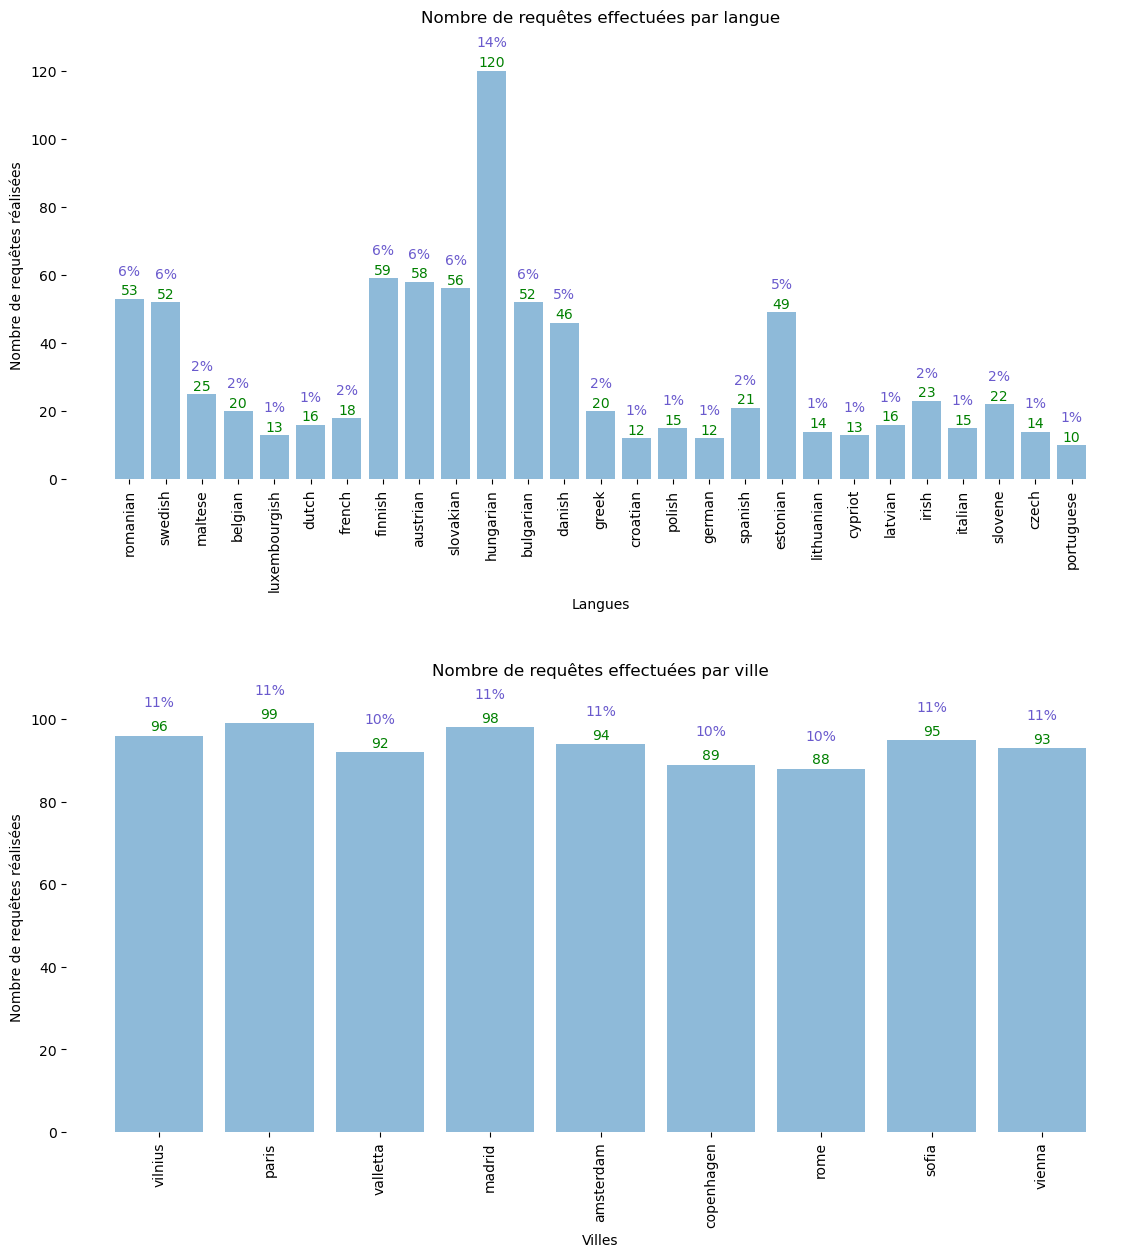

In [7]:
plotCityLanguage(data)

<font color = "blue" > Avec le premier graphe, on observe que toutes les langues (27 en tout) sont représentées dans le set de test.\
Les langues les plus présentes sont: 
- <font color = "blue" > hungarian (14%)
- <font color = "blue" > romanian, swedish, finish, austrian, slovakian, bulgarian, danish, estonian (5-6%)
- <font color = "blue" > Les autres langues ont une présence inféireure ou égale à 2%

<font color = "blue" > Avec le deuxième graphe, on observe que toutes les villes sont présentes en proportions égales dans le set de test.

## Répartition de la variable date

In [8]:
def plotDates(data):
    """
    Cette fonction trace la répartition de la variable date
    """
    
    dates_requests = data[["order_requests","date"]].drop_duplicates()
    
    fig, ax = plt.subplots(figsize=(20,8))

    counts, edges, bars = ax.hist(dates_requests.date,bins=len(dates_requests)//10, density=False,alpha = .5)

    ax.bar_label(bars,padding = 1,size = 12)
    ax.set_xticks(np.arange(0,41))
    ax.set_title("Nombre d'avatars par nombre de requêtes réalisées")
    ax.set_xlabel("valeur de date")
    ax.set_ylabel("nombre d'occurrences")

    ax.spines[['top','right','left']].set_visible(False)
    plt.show()

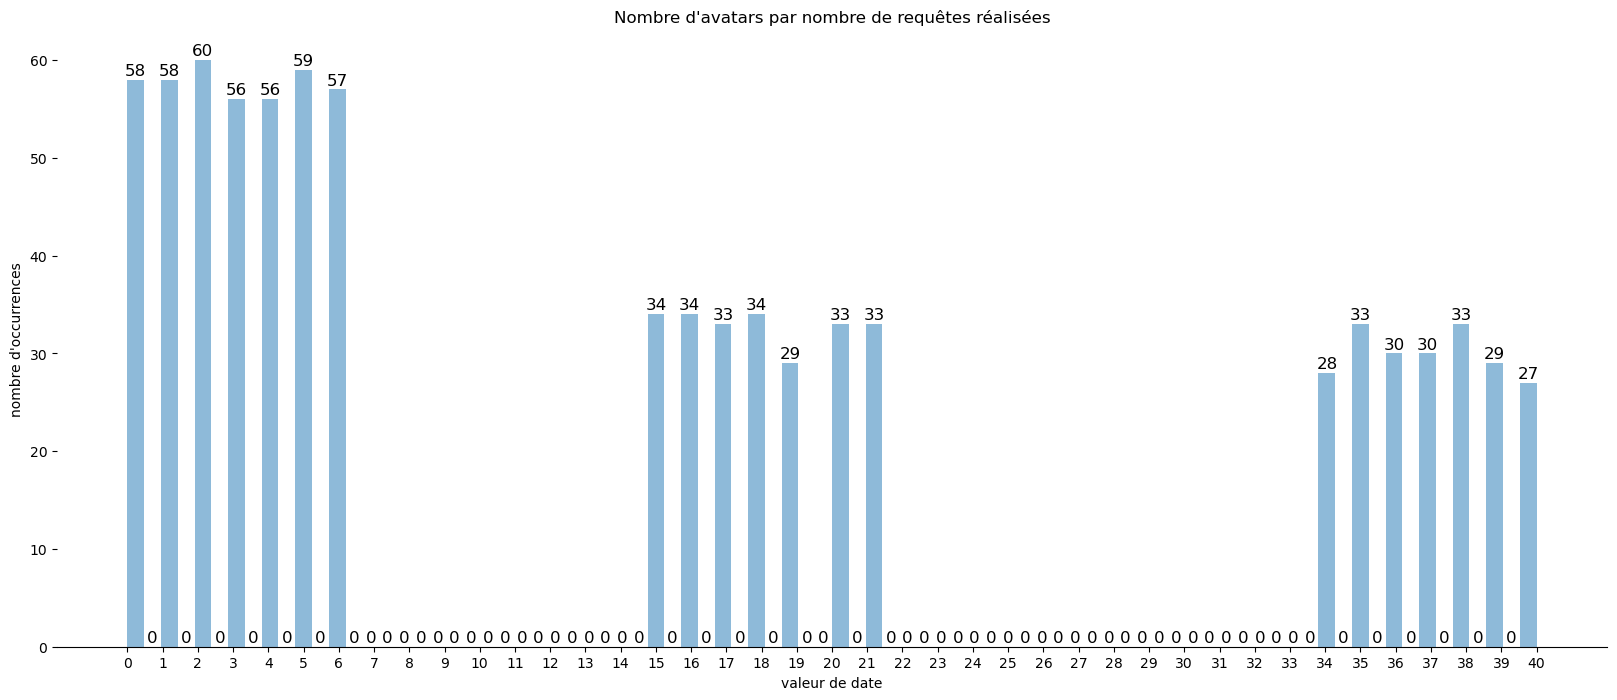

In [9]:
plotDates(data)

<font color = "blue" > Avec ce graphe, on observe que les valeurs de la variable date ne sont pas réparties uniformément. Les dates présentes sont: 
- <font color = "blue" > 0 à 6 jours (404 dates) 
- <font color = "blue" > 15 à 21 jours (230 dates)
- <font color = "blue" > 34 à 40 jours (210 dates)

In [10]:
## Calcul du nombre de requêtes par personne

In [11]:
# Extraction de l'information
#----------------------------------------
def computeNbRequestPerAv(data):
    """
    Cette fonction calcule le nombre d'avatars ayant réalisé ayant réalisé 1 requête, 
    le nombre d'avatars ayant réalisé 2 requête, le nombre d'avatars ayant réalisé 2 requêtes...
    
    ---> input: 
    * data (dataframe): données 
    ---> output: 
    * statsNbResquest (dataframe): 
        - en index: le nb de requêtes n
        - en valeur: le nb d'avatars ayant réalisé n requêtes
    """
    
    # Création d'une dataframe ne contenant que les colonnes 'avatar_id' et 'order_requests'.
    # On enlève les doublons: il ne reste qu'un seul exemplaire de chaque couple ('avatar_id','order_requests')
    avatar_request = data[["avatar_id","order_requests"]].drop_duplicates()
    
    # Compte le nombre de "avatar_id" identiques dans "avatar_request". 
    # On obtient un dataframe avec en index: avatar_id et en valeur: le nb de requêtes par avatar_id
    nbRequestPerAv = avatar_request["avatar_id"].value_counts() 
    
    # Compte le nombre d'avataers ayant fait 1 requête, le nombre de fois où on a fait 2 requêtes...
    statsNbRequest = nbRequestPerAv.value_counts() #.to_dict() 

    return statsNbRequest

## vérification: data.iloc[np.where(data.avatar_id == 78)] 

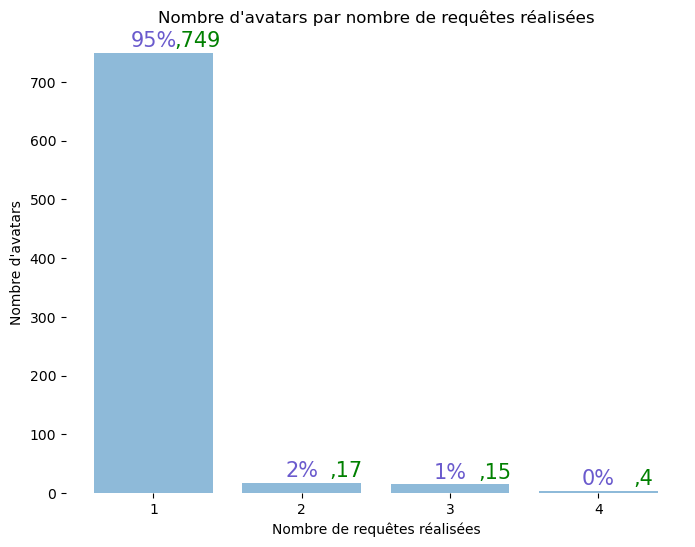

In [12]:
def plotNbRequestPerAv(data):
    """
    Cette fonction utilise le résultat de computeNbRequestPerAv() et plot un barplot du 
    nombre d'avatars par nombre de requête.
    Affiche aussi le pourcentage (en bleu) et le nombre réel (en vert) d'avatars par nb de requête.
    
    ---> input: 
    * data (dataframe): données  
    """
    statsNbRequest = computeNbRequestPerAv(data) 

    fig, ax = plt.subplots(figsize=(8,6))
    plt.bar(statsNbRequest.index, statsNbRequest.values,alpha=.5)

    ax.set_title("Nombre d'avatars par nombre de requêtes réalisées")
    ax.set_xlabel("Nombre de requêtes réalisées")
    ax.set_ylabel("Nombre d'avatars")
    plt.xticks(statsNbRequest.index)

    per = 100 * statsNbRequest.values/sum(statsNbRequest.values) 
    #calcul en pourcentage du nombre d'avatars par nombre de requêtes réalisées

    j=0
    for i, v in enumerate(statsNbRequest.values):   
        ax.text(i+1, v+10, str("%d" % per[j]) + "%" , ha="center",color = 'slateblue', size = 15, rotation = 0)  
        j+=1
        
    for i, v in enumerate(statsNbRequest.values):   
        ax.text(i+1.30, v+10, ',' + str(v) , ha="center",color = 'green', size = 15, rotation = 0) 

    ax.spines[['top','right','bottom','left']].set_visible(False)

    plt.show()
    
plotNbRequestPerAv(data)

In [13]:
statsNbRequest = computeNbRequestPerAv(data)
print("Nombre total d'avatars : ", sum(statsNbRequest))
print("Nombre d'avatars ayant fait + de 1 requête: {} soit {}%". format(
    sum(statsNbRequest.iloc[1:]), 
    round(sum(statsNbRequest.iloc[1:])*100/sum(statsNbRequest),2))
     )

Nombre total d'avatars :  785
Nombre d'avatars ayant fait + de 1 requête: 36 soit 4.59%


<font color = "blue" > On remarque que la grande majorité des avatars du set de test n'ont fait qu'une seule requête. Seulement 4,59% des avatars ont réalisé plusieurs requêtes. Le nombre de requêtes réalisé par un même avatar ne dépasse pas 4 requêtes. \
Dans un premier temps, il n'est peut-être pas pertinent de faire plusieurs requêtes pour un même avatar. 

## Calul du nombre de personnes ayant utilisé plusieurs langues pour leurs requêtes

<font color = "blue" > 
Une requête peut être effectuée qu'en une seule langue.
    
    
Un même avatar peut faire plusieurs requêtes et donc utiliser plusieurs langues.

In [14]:
def computeSeveralLanguage(data):
    """
    Cette fonction extrait les avatars ayant fait des requêtes dans plusieurs langues.
    
    ---> input: 
    * data (dataframe): données 
    ---> output: 
    * df_avatar_language (dataframe): contenant pour chaque avatar ayant utilisé plusiueurs langues: 
        - colonne "avatar_id": id de l'avatar ayant utilisé plusieurs langues
        - colonne "language_used": langues utilisées par de l'avatar
        - colonne "nb_requests": nombre total de requêtes envoyées par l'avatar ayant utilisé plusieurs langues
    """

    # Création d'une dataframe ne contenant que les colonnes 'avatar_id','order_requests','language'
    # On enlève les doublons: il ne reste qu'un seul exemplaire de chaque trio ('avatar_id','order_requests','langue')
    avatar_language = data[["avatar_id","order_requests","language"]].drop_duplicates()

    # Calcul d'un dataframe avec en index: avatar_id et en valeur: le nb de requêtes par avatar_id
    nbRequestPerAv = avatar_language["avatar_id"].value_counts() 

    # Calcul des ids des avatars ayant fait + de 1 requête
    idx_avatar_severalR = nbRequestPerAv.iloc[np.where(nbRequestPerAv>1)].index 

    avatars_severalL = [] #liste contenant les ids des avatars utilisant plusieurs langues
    language_used = [] #liste contenant les langues utilisées si on a trouvé que l'avatar utilise plusieurs langues
    nb_requests_a = [] #liste contenant le nb de requêtes 

    # On itère sur les avatars ayant eu + de 1 requête
    for a in idx_avatar_severalR:
        # compte le nombre de langues utilisées pour 1 avatar donné
        # on rapelle qu'à une requête correspond 1 langue
        langues = Counter(avatar_language["language"].iloc[np.where(avatar_language.avatar_id == a)]) 
        if len(langues) > 1: #si il y a utilisation de + d'un langue...
            avatars_severalL.append(a) #on sauve l'id de l'avatar utilisant plusieurs langues
            language_used.append(list(langues.keys())) #on sauve les langues utilisées 
            nb_requests_a.append(nbRequestPerAv[a])

    # Concatenate all information into a dataframe
    df_avatar_language = pd.DataFrame() 
    df_avatar_language["avatar_id"] = avatars_severalL
    df_avatar_language["language_used"] = language_used
    df_avatar_language["nb_requests"] = nb_requests_a

    return df_avatar_language

df_avatar_language = computeSeveralLanguage(data)
df_avatar_language

,avatar_id,language_used,nb_requests
0,789,"[czech, lithuanian]",4
1,12,"[romanian, bulgarian]",4
2,5,"[luxembourgish, dutch]",3
3,27,"[austrian, french, spanish]",3
4,4,"[belgian, luxembourgish]",3
5,6,"[belgian, french]",3
6,11,"[austrian, french]",3
7,791,"[belgian, french]",3
8,8,"[austrian, slovakian]",3
9,7,"[finnish, swedish]",2


<font color = "blue" > Parmi les 36 avatars ayant réalisé plusieurs requêtes, 1/3 des avatars (12 avatars) ont utilisé des langues différentes pour leurs requêtes. Le nombre de langues utilisées est 2, seul un avatar a utilisé 3 langues. 

## Calul du nombre de personnes ayant utilisé le téléphone et l'ordinateur

In [15]:
def computeSeveralDevices(data):
    """
    Cette fonction extrait les avatars ayant fait des requêtes avec plusieurs devices différents
    (ordinateur et mobile)
    
    ---> input: 
    * data (dataframe): données 
    ---> outputs: 
    * df_avatar_device (dataframe): contenant pour chaque avatar ayant utilisé plusiueurs devices: 
        - colonne "avatar_id": id de l'avatar ayant utilisé plusieurs devices
        - colonne "nb_mobiles": nombre de requêtes envoyées avec un mobile
        - colonne "nb_computers": nombre de requêtes envoyées avec un ordinateur
        - colonne "nb_requests": nombre total de requêtes envoyées par l'avatar ayant utilisé plusieurs devices
    * totNb_requests  (int): nombre total de requêtes 
    * totNb_mobiles   (int): nombre total de requêtes effectuées avec un mobile
    * totNb_computers (int): nombre total de requêtes effectuées avec un ordinateur
    """

    # Création d'une dataframe ne contenant que les colonnes 'avatar_id','order_requests','mobile'
    # On enlève les doublons: il ne reste qu'un seul exemplaire de chaque trio ('avatar_id','order_requests','mobile')
    avatar_mobile = data[["avatar_id","order_requests","mobile"]].drop_duplicates()
    
    totNb_requests = len(avatar_mobile) #nombre total de requêtes 
    totNb_mobiles = Counter(avatar_mobile["mobile"].values)[0] #nombre total de requêtes effectuées avec un mobile
    totNb_computers = Counter(avatar_mobile["mobile"].values)[1]  #nombre total de requêtes effectuées avec un ordinateur

    # Calcul d'une dataframe avec en index: avatar_id et en valeur: le nb de requêtes par avatar_id
    nbRequestPerAv = avatar_mobile["avatar_id"].value_counts()

    # Calcul des ids des avatars ayant fait + de 1 requête
    idx_avatar_severalR = nbRequestPerAv.iloc[np.where(nbRequestPerAv>1)].index 


    avatars_severalD = [] #liste contenant les ids des avatars utilisant plusieurs devices (mobile et ordi)
    mobiles_used = [] #liste contenant le nb de mobiles utilisés
    computer_used = [] #liste contenant le nb d'ordinateurs utilisés
    nb_requests_a = [] #liste contenant le nb de requêtes 

    # On itère sur les avatars ayant eu + de 1 requête
    for a in idx_avatar_severalR:
        d = Counter(avatar_mobile["mobile"].iloc[np.where(avatar_mobile.avatar_id == a)])
        #dictionnaire contenant le nombre de "mobile = 1" et le nombre de "mobile = 0" (ordinateur)

        if len(d) > 1: #si l'avatar "a" a utilisé un ordi et un mobile
            avatars_severalD.append(a) #on sauve l'id de l'avatar utilisant plusieurs devices
            mobiles_used.append(d[1]) #on sauve le nb de mobiles utilisées 
            computer_used.append(d[0]) #on sauve le nb d'ordis utilisées 
            nb_requests_a.append(nbRequestPerAv[a])

    # Concatenate all information into a dataframe
    df_avatar_device = pd.DataFrame() 
    df_avatar_device["avatar_id"] = avatars_severalD
    df_avatar_device["nb_mobiles"] = mobiles_used
    df_avatar_device["nb_computers"] = computer_used
    df_avatar_device["nb_requests"] = nb_requests_a
    
    return df_avatar_device, totNb_requests, totNb_mobiles, totNb_computers

df_avatar_device, totNb_requests, totNb_mobiles, totNb_computers = computeSeveralDevices(data)

print("Nombre total de requêtes: ",totNb_requests)
print("Nombre total de requêtes effectuées avec un mobile: {} requêtes soit {} %".format(totNb_mobiles,
                            round(totNb_mobiles*100/totNb_requests,2)))
print("Nombre total de requêtes effectuées avec un ordinateur: {} requêtes soit {} %".format(totNb_computers,
                            round(totNb_computers*100/totNb_requests,2)))

print("\nAffichage des avatars ayant effectué des requêtes avec des devices différents (mobiles et ordinateurs): ")
df_avatar_device

Nombre total de requêtes:  844
Nombre total de requêtes effectuées avec un mobile: 453 requêtes soit 53.67 %
Nombre total de requêtes effectuées avec un ordinateur: 391 requêtes soit 46.33 %

Affichage des avatars ayant effectué des requêtes avec des devices différents (mobiles et ordinateurs): 


,avatar_id,nb_mobiles,nb_computers,nb_requests
0,794,3,1,4
1,789,1,3,4
2,12,3,1,4
3,5,2,1,3
4,13,1,2,3
5,2,2,1,3
6,793,1,2,3
7,4,1,2,3
8,6,2,1,3
9,14,2,1,3


<font color = "blue" > On observe que environ la moitié des avatars ont utilisé un ordinateur et l'autre moitié un mobile. On peut donc effectuer des requêtes avec des mobiles et des ordinateurs dans des proportions égales. 
    
<font color = "blue" > Parmi les 36 avatars qui ont effectué plusieurs requêtes, la moitié (18 avatars) ont utilisé à la fois le mobile et l'ordinateur. 

##  Conclusion de la partie analyse : 

<font color="blue"> 
    
- Nous avons concentrer nos requêtes sur les 3 périodes de dates identifiées.
    
- Dans un premier temps, nous avons fait une requête par avatar, puis 2 et 3 requêtes dans un second temps et dans un nnombre restreint.
    
- Les variables mobile, ville ... sont traité de manière unifrme et aléatoire.
    
- Des requêtes spéciales ont été faites sur les langues les plus présentes. (puis aléatoire lorsque l'analyse des résultats a révélée un faible impacte de la langue.

# Interprétabilité des modèles

<font color='blue'>

L'objectif est d'expliquer les features les plus influentes dans la prédiction des prix d'hôtels. 

Nous allons utiliser des méthodes agnostiques, c'est à dire utilisant le modèle comme une boîte noire.


On considère à la fois des méthodes globales qui étudient le comportement général du modèle (importance de chaque feature dans la prédiction du​ modèle).​On peut utiliser une méthode locale, où le but est de fournir une explication pour un exemple très précis => expliquer un comportement individuel.

In [26]:
import catboost
import category_encoders

import matplotlib.pyplot as plt
import seaborn as sns


utilities_folder = '../utilities'
os.chdir(utilities_folder)

PATH_MODELS = '../models'
PATH_DATA = '../data'

In [ ]:
'''!pip install category_encoders
!pip install catboost
'''

## Chargement des modèles

In [27]:
name_testKaggle = "test_set_cleaned_addedFeatures.csv"
name_requests = 'pricing_requests_clean.csv'
name_featHotels = 'features_hotels.csv'


## Pour faire tourner ce code ils faut être dans le docker 

#!python models.py --train 1 --name 3 --adversarial 0 --hotelid 1 --name_save "lxgboost_no_adversarial_dd.sav" --drop_duplicates 1 --save_train_test 1
#!python models.py --train 1 --name 3 --adversarial 1 --hotelid 1 --name_save "lxgboost_adversarial_dd.sav" --drop_duplicates 1 --save_train_test 1
#!python models.py --train 1 --name 1 --adversarial 0 --hotelid 1 --name_save "rf_no_adversarial_dd.sav" --drop_duplicates 1 --save_train_test 1
#!python models.py --train 1 --name 1 --adversarial 1 --hotelid 1 --name_save "rf_adversarial_dd.sav" --drop_duplicates 1 --save_train_test 1
#!python models.py --train 1 --name 0 --adversarial 0 --hotelid 1 --name_save "xgb_no_adversarial_dd.sav" --drop_duplicates 1 --save_train_test 1
#!python models.py --train 1 --name 0 --adversarial 1 --hotelid 1 --name_save "xgb_adversarial_dd.sav" --drop_duplicates 1 --save_train_test 1
#!python models.py --train 1 --name 2 --adversarial 0 --hotelid 1 --name_save "cat_no_adversarial_dd.sav" --drop_duplicates 0 --save_train_test 1
#!python models.py --train 1 --name 2 --adversarial 1 --hotelid 1 --name_save "cat_adversarial_dd.sav" --drop_duplicates 1 --save_train_test 1

/usr/local/insa/anaconda/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
début de la création des datasets (train, test, validation
0 features_hotels.csv 1 1
Traceback (most recent call last):
  File "/home/kolb/5A/IA framework/Defi-IA-bedbugs/utilities/models.py", line 305, in <module>
    X_train,Y_train,X_val,Y_val,X_test,Y_test = DP.main_data_preprocessing(
  File "/home/kolb/5A/IA framework/Defi-IA-bedbugs/utilities/data_preprocessing.py", line 469, in main_data_preprocessing
    pricing_requests = retrieve_data(name_requests,name_featHotels)
  File "/home/kolb/5A/IA framework/Defi-IA-bedbugs/utilities/data_preprocessing.py", line 50, in retrieve_data
    pricing_requests = pd.read_csv(PATH_DATA + '/' + name_requests)
  File "/usr/local/insa/anaconda/lib/python3.9/site-packages/pandas/

In [29]:
# Importation des modèles interprété (nous gardons ici un échantillons d'interprétabilité intérressant)

#lxgb_noad_val = pickle.load(open(PATH_MODELS + "/lxgboost_no_adversarial_dd.sav", 'rb'))
#lxgb = pickle.load(open(PATH_MODELS + "/lxgboost_adversarial_dd.sav", 'rb'))
#rf_noad_val = pickle.load(open(PATH_MODELS + "/rf_no_adversarial_dd.sav", 'rb'))
#rf = pickle.load(open(PATH_MODELS + "/rf_adversarial_dd.sav", 'rb'))
#xgb_noad_val = pickle.load(open(PATH_MODELS + "/xgb_no_adversarial_dd.sav", 'rb'))
#xgb = pickle.load(open(PATH_MODELS + "/xgb_adversarial_dd.sav", 'rb'))
#cat_noad_val = pickle.load(open(PATH_MODELS + "/cat_no_adversarial_dd.sav", 'rb'))
#cat = pickle.load(open(PATH_MODELS + "/cat_adversarial_dd.sav", 'rb'))

In [30]:
# disponible si un modèle à été compilé
'''
X_train = pd.read_csv(PATH_DATA + '/X_train.csv', index_col = 0)
X_test = pd.read_csv(PATH_DATA + '/X_test.csv', index_col = 0)
Y_train = pd.read_csv(PATH_DATA + '/Y_train.csv', index_col = 0)
Y_test = pd.read_csv(PATH_DATA + '/Y_test.csv', index_col = 0)

X_train.drop("request_number", axis=1, inplace = True)
X_test.drop("request_number", axis=1, inplace = True)
X_train.drop("hotel_id", axis=1, inplace = True)
X_test.drop("hotel_id", axis=1, inplace = True)'''

'\nX_train = pd.read_csv(PATH_DATA + \'/X_train.csv\', index_col = 0)\nX_test = pd.read_csv(PATH_DATA + \'/X_test.csv\', index_col = 0)\nY_train = pd.read_csv(PATH_DATA + \'/Y_train.csv\', index_col = 0)\nY_test = pd.read_csv(PATH_DATA + \'/Y_test.csv\', index_col = 0)\n\nX_train.drop("request_number", axis=1, inplace = True)\nX_test.drop("request_number", axis=1, inplace = True)\nX_train.drop("hotel_id", axis=1, inplace = True)\nX_test.drop("hotel_id", axis=1, inplace = True)'

## Permutations

<font color="blue">
Dans cette partie, nous utilisons les permutations pour établir les features les plus importantes. 
    
    
    
Nous utilisons la librairie eli5. 
    
    
    
Cette méthode s'applique sur les modèles basés sur les arbres.
    


Cette méthode est une méthode d'interprétabilité globale, qui consiste à créer un dataset avec des instances perturbées (modification par permutation de la valeur des features)​, puis à faire de l'inférence sur ces instances​, à mesurer l’erreur de prédiction, puis à trier les features par ordre d'importance (plus l'erreur est grande, plus l'importance est élevée. On voit que les importances diffèrent selon les méthodes. 
    
<font color="blue">
Remarque : avant de supprimer hotel_id, c'était la feature qui avait le plus d'importance et les autres features avaient un impact quasiment nul. Après la suppression de cette feature de notre modèle qui est en fait une combinaison des autres features (brand, group, nb_tourists). Le feature le plus important est la brand (marque) dans tous les cas, suivi du groupe, stock, city, date pour les méthodes de boosting. Pour les autres méthodes ces features les plus importantes sont stock, city, price_m2, group et date. 

### Code

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
# Installation de la librairie Eli5
#!pip install eli5 > /dev/null 2>&1''

In [ ]:
list_model = [lxgb_noad_val, rf_noad_val, rf, lxgb]
list_name = ['light xgboost', 'random forest', 'random forest adversarial val', 'light xgboost adversarial val']

feature_names= X_train.columns.tolist()
features_importance_dict = {}
for model, name in zip(list_model, list_name):
    plt.figure()
    permumtation_impor = PermutationImportance(model, random_state=0).fit(X_test, Y_test)
    features_importance = {'Feature_name':feature_names, 'Importance':permumtation_impor.feature_importances_}  
    features_importance = pd.DataFrame(features_importance) 
    features_importance = features_importance.sort_values(['Importance'], ascending=False) 
    features_importance_dict[name] = features_importance
    ax = sns.barplot(x="Importance", y="Feature_name", data=features_importance)
    plt.title(name)

###  <font color="blue"> Résultats

<font color="blue">

Permutation importance for random forest modèle sans  adversarial validation :

Il y a 4 features qui se distinguent : 
- brand
- stock
- ville
- prix au mètre carré


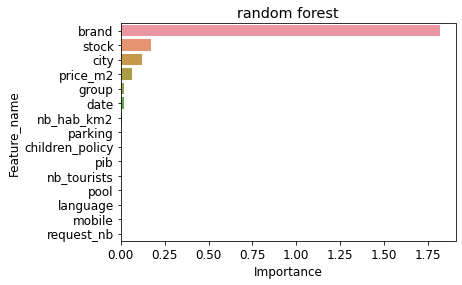<img 

<font color="blue">
    
Permutation importance for random forest modèle avec adversarial validation :

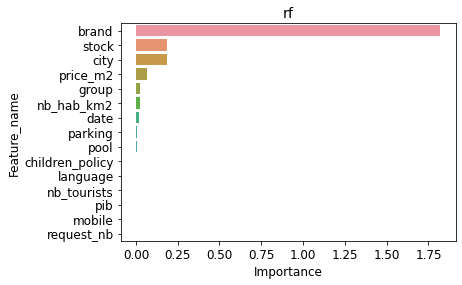

<font color="blue">
    
Permutation importance pour le modèle lxgb sans adversarial validation :

5 features se distinguant :
- brand
- group
- stock
- city
- date

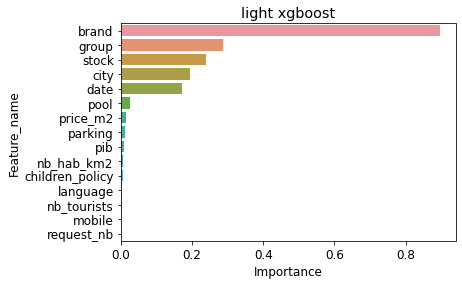

<font color="blue">
Permutation importance avec adversarial validation :

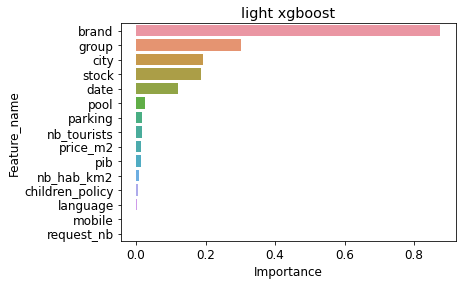

<font color="blue">
Remarque : avant de supprimer hotel_id, c'était la feature qui avait le plus d'importance et les autres features avaient un impact quasiment nul. Après la suppression de cette feature de notre modèle qui est en fait une combinaison des autres features (brand, group, nb_tourists). Le feature le plus important est la brand (marque) dans tous les cas, suivi du groupe, stock, city, date pour les méthodes de boosting. Pour les autres méthodes ces features les plus importantes sont stock, city, price_m2, group et date. 

## PDP and ICE plots



<font color = "blue" > 
Nous utilisons la librairie 'pdpbox'.

In [31]:
### Codes

In [ ]:
#!pip install pdpbox > /dev/null 2>&1
import pdpbox

In [ ]:
from pdpbox import pdp, get_dataset, info_plots

model = lxgb 
model_name = 'light xgboost adversarial val'

top_features = features_importance_dict[model_name].Feature_name[:5].values
for i, feature in enumerate(top_features, 1):
    pdp_feat = pdp.pdp_isolate(model=model, dataset=X_test, model_features=feature_names, feature=feature)
    pdp.pdp_plot(pdp_feat, feature, plot_lines=True, frac_to_plot=0.1, figsize=(10,5))
    plt.show()

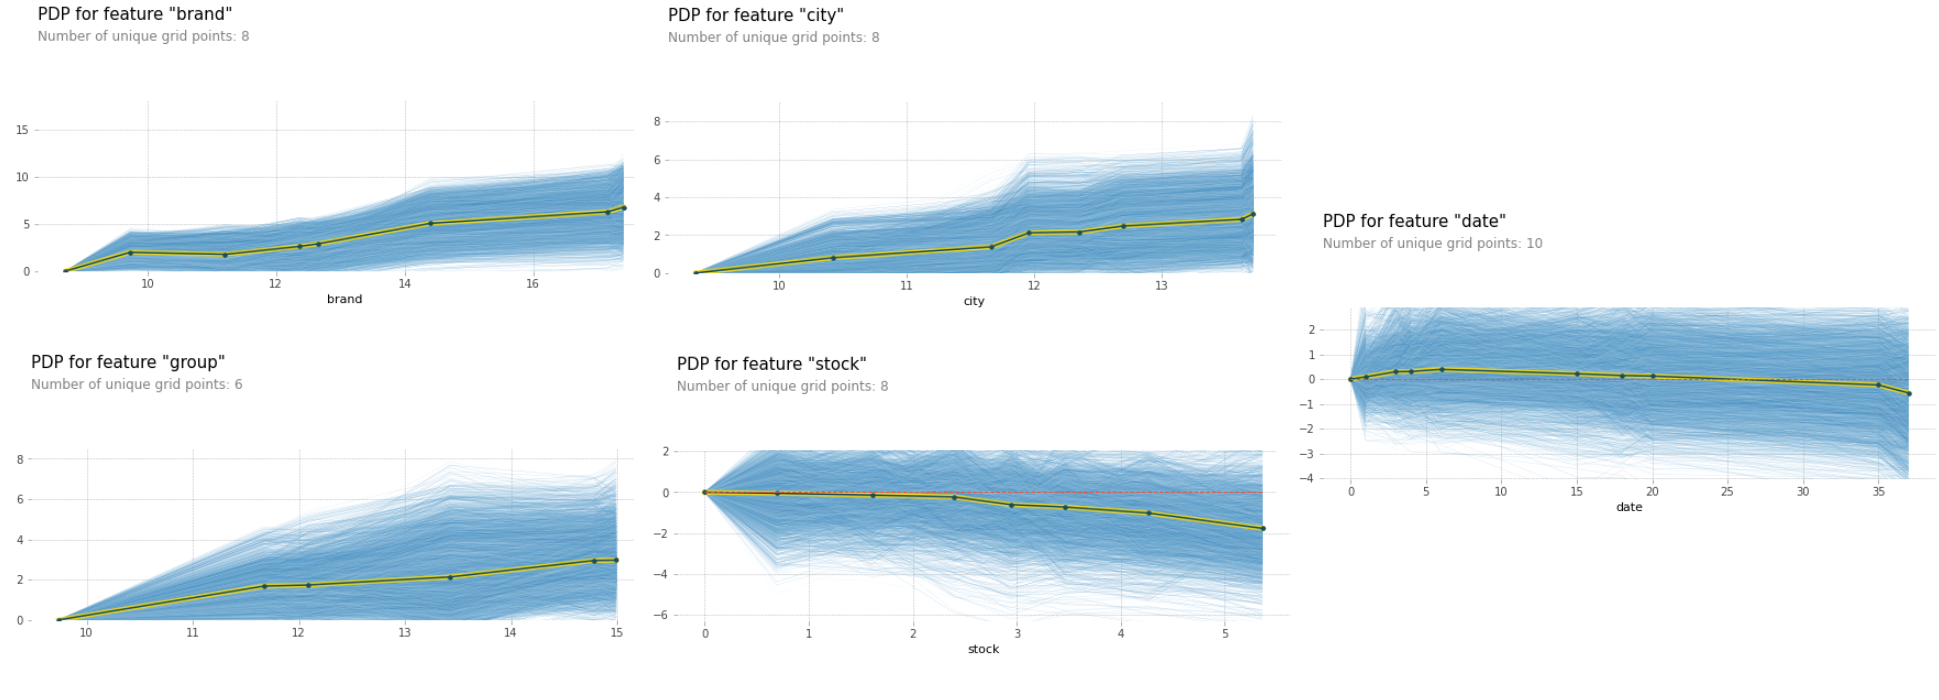

In [ ]:
from pdpbox import pdp, get_dataset, info_plots
model = rf 
model_name = 'random forest adversarial val'

top_features = features_importance_dict[model_name].Feature_name[:4].values
for i, feature in enumerate(top_features, 1):
    pdp_feat = pdp.pdp_isolate(model=model, dataset=X_test, model_features=feature_names, feature=feature)
    pdp.pdp_plot(pdp_feat, feature, plot_lines=True, frac_to_plot=0.1, figsize=(10,5))
    plt.show()

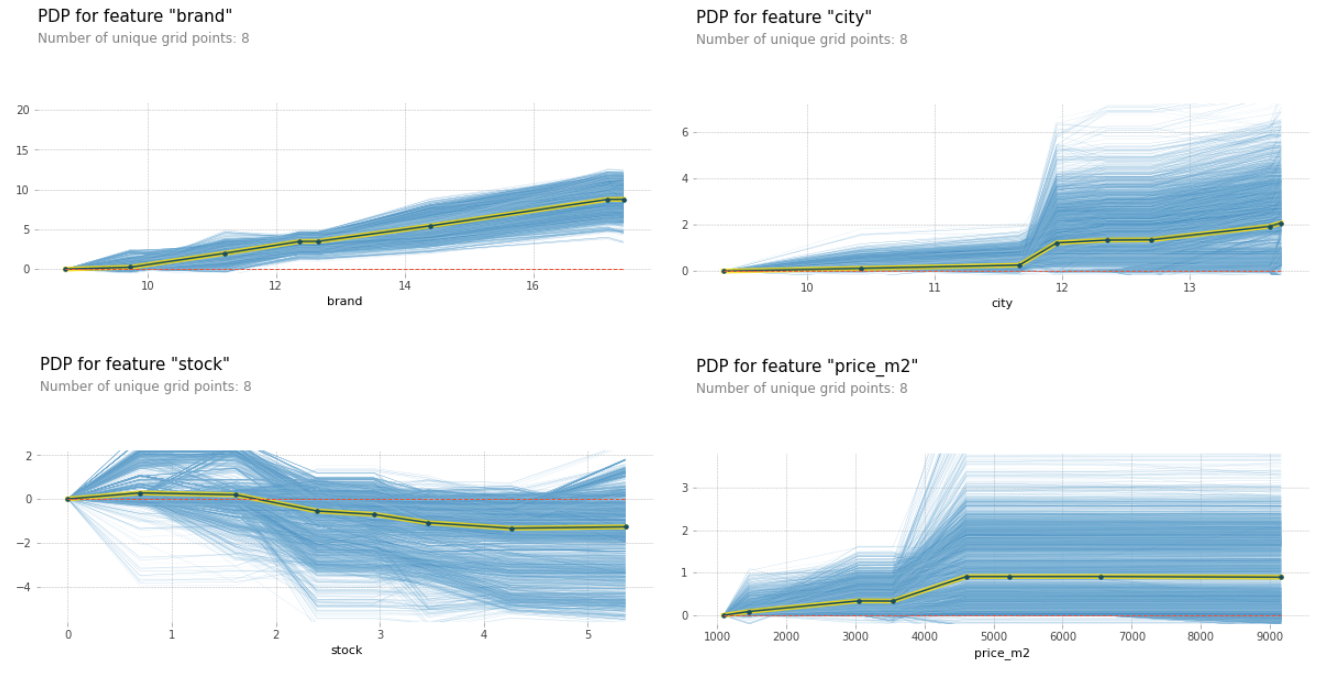

 ###  Interprétations :    

<font color="blue"> 
    
 - Une pente raide indique une relation forte entre la variable d'entrée et la variable cible, tandis qu'une pente faible indique une relation plus faible.

<font color="blue">  
    
 - Si la ligne a une pente croissante, cela indique une relation positive (c'est-à-dire que lorsque la variable d'entrée augmente, la variable cible augmente également). Si la ligne a une pente décroissante, cela indique une relation négative (c'est-à-dire que lorsque la variable d'entrée augmente, la variable cible diminue).

<font color="blue">  
    
 - Si la ligne n'est pas droite, cela peut indiquer une relation non linéaire.

<font color="blue">  Dans nos modèles, on voit que la variable brand a une pente forte donc la relation est forte entre le prix et la brand.
Le stock a une relation inversement proportionnelle, plus il y a de stock moins la chambre est chère.
<font color="blue">  Il y a également une relation entre la ville et le prix ainsi que le prix au mètre carré jusqu'à un certain seuil ou l'influence n'augmente pas.
La relation avec la date est assez faible. on aubserve néanmoins une légère augmentation lorsque la date est proche et une légère diminution lorsque la date est éloignée.

## Plot des effets combinés de 2 fonctions : 

### Codes

In [ ]:
model = lxgb

features_to_plot = ['stock', 'date']
inter1 = pdp.pdp_interact(model=model, dataset=X_test, model_features=feature_names, features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

features_to_plot = ['brand', 'group']
inter1 = pdp.pdp_interact(model=model, dataset=X_test, model_features=feature_names, features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

features_to_plot = ['nb_tourists', 'stock']
inter1 = pdp.pdp_interact(model=model, dataset=X_test, model_features=feature_names, features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

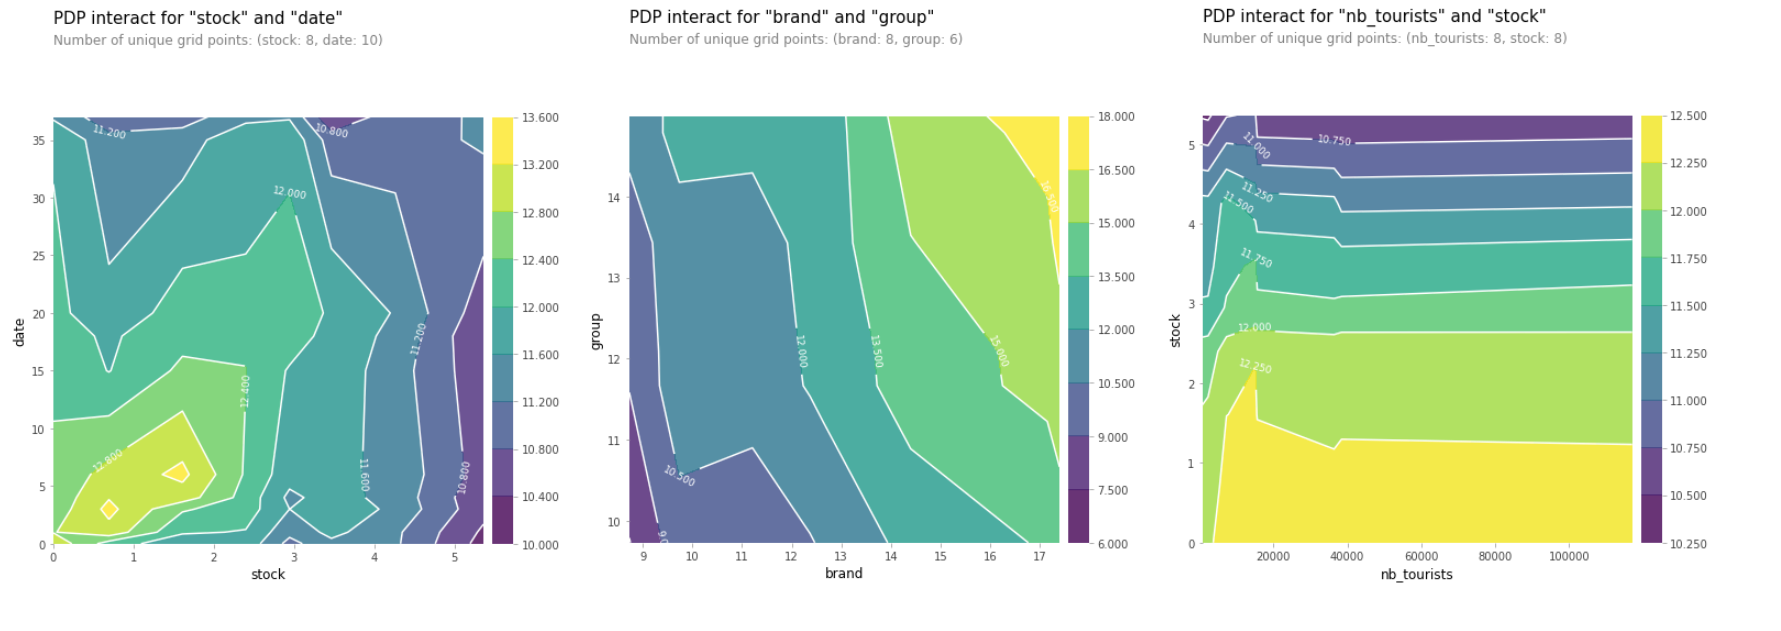

In [ ]:

features_to_plot = ['stock', 'date']
inter1 = pdp.pdp_interact(model=model, dataset=X_test, model_features=feature_names, features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

features_to_plot = ['brand', 'group']
inter1 = pdp.pdp_interact(model=model, dataset=X_test, model_features=feature_names, features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

features_to_plot = ['nb_tourists', 'stock']
inter1 = pdp.pdp_interact(model=model, dataset=X_test, model_features=feature_names, features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

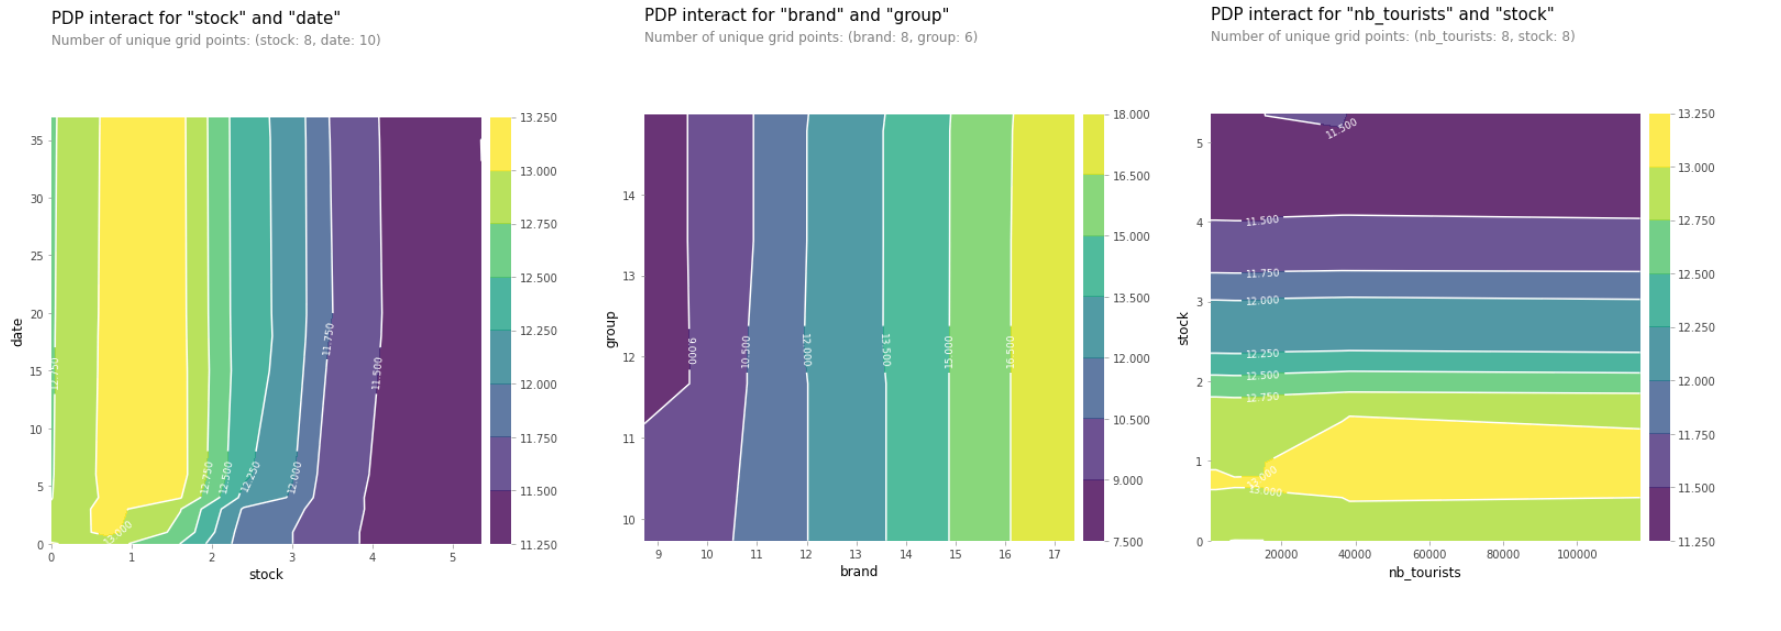

### <font color="blue"> Interprétations : 

<font color="blue"> Droites horizontales ou verticales = pas d'intéractions.

<font color="blue"> Pour le modèle lxgb : intéraction entre la date et le stock : plus la date est proche, plus le stock est bas.

<font color="blue"> Pour le model random forest : pas d'intéractions.

## SHAP

<font color="blue">  

Les méthodes SHAP est une interprétation locale (contrairement aux interprétations ci-dessus qui étaient locales). Elles se basent sur ls valeurs de Shapley.

Nous utilisons la librairie SHAP.


### Codes

<font color="red"> L'exécution de cette méthode est particulièrement longue. On a donc choisi de l'exécuter seulement sur le modèle rf. 

In [ ]:
#import Shap
#!pip install shap > /dev/null 2>&1

In [ ]:
feature_names=["stock", "brand", "price_m2", "city"]

shap.initjs() #needed to plot results directly on the notebook
model = rf
#idx = 1 # index of the instance we want to explain

X_test = shap.sample(X_test, 10000)#faire décroitre le nombre de données pour ne pas avoir de problème de mémoire
explainer = shap.KernelExplainer(model.predict, X_test)
shap_values = explainer.shap_values(X_test.iloc[0,:])
shap.force_plot(explainer.expected_value, shap_values, X_test.iloc[0,:], matplotlib=True)

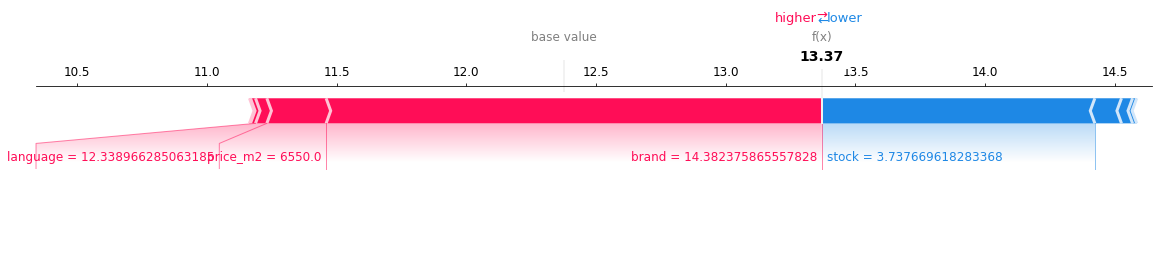

In [ ]:
shap_values = explainer.shap_values(X_test.iloc[0:20,:]) #To speed up we just compute the shap values for 100 exemples
shap.summary_plot(shap_values, X_test.iloc[0:20,:])

Résultat avec le modèle random forest, et uniquement 10000 valeurs test

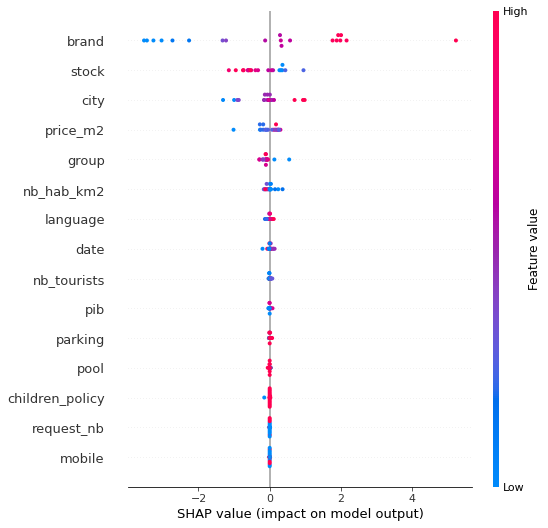

### Interprétations : 
    
<font color='blue'> 

C'est une méthode Locale.
    
 On observe ici les différentes valeurs de shapley qui mesurent l'importance relative de chaque variable dans la valeur de la prédition finale. La valeur de shapley est calculée en faisant la moyenne de la différence entre la prédiction du modèle avec et sans une feature/un groupe de features. Ici, on cherche à expliquer 20 prédictions individuelles en montrant l'importance de chaque feature pour les 20 prédictions considérées. 
    
On voit bien que les valeurs des shapleys sont importantes en valeur absolue pour la brand, le stock, la ville et le prix au mètre carré. A l'inverse, les valeurs des shapleys sont nulles pour tous les individus pour la variable mobile, request_nb, children_policy, pool, parking, pib, nb_tourists, date}}

## Lime  

<font color='blue'> 

Lime est une méthode locale agnostique.

Remarque importante: prix prédit correspond a predicted value^2
    
    
<font color="blue"> Cette méthode est une méthode locale, qui permet d'expliquer la variable de sortie prix​. On commence par sélectionner l'individu qui a un prix​ donné (la valeur sur le graphique à gauche est sélectionnée et diffère à chaque exécution du code (car sélectionnée de manière aléatoire). Ensuite, il y a perturbation de cette instance, puis construction d'un modèle local (régression). Les coefficients correspondent aux coefficients de la régressions ~ importance des variables dans la prédiction locale autour de l'individu​.

### Codes

In [35]:
#!pip install lime > /dev/null 2>&1


In [36]:
import lime
import lime.lime_tabular
model = lxgb
index = 0

explainer = lime.lime_tabular.LimeTabularExplainer(X_test.values, feature_names=feature_names, mode="regression")
exp = explainer.explain_instance(X_test.iloc[index], model.predict, num_features=5, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=True)

ModuleNotFoundError: No module named 'lime'

<font color='blue'> 

Pour le model light Xgboost, on retrouve bien les 5 features des parties précédentes.

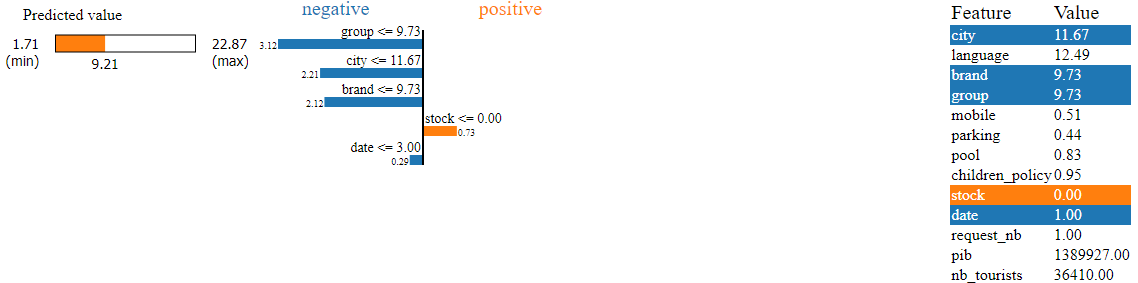

In [ ]:
model = rf
index = 0

explainer = lime.lime_tabular.LimeTabularExplainer(X_test.values, feature_names=feature_names, mode="regression")
exp = explainer.explain_instance(X_test.iloc[index], model.predict, num_features=5, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=True)

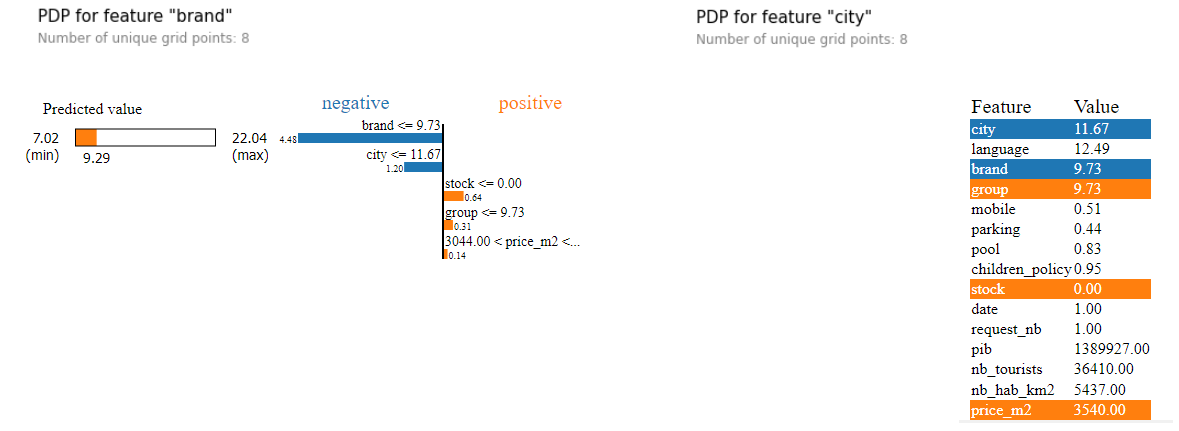

<font color='blue'>

On retrouve bien que la brand et le group sont des features importantes. La ville est dans tous les cas un feature très important. Le stock est aussi toujours un feature important même à l'échelle d'un individu. 